In [3]:
! pip install langdetect
! pip install transformers
! pip install rake_nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from rake_nltk import Rake
import transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=db1c2fb6cd26107d828c93836b6ed733d66820d1d0c46881d6ab0ed4479298c2
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.0 MB/s eta 0:00:00


In [4]:
def isEnglish(text):
    try:
        lang = detect(text)
        if lang == 'en':
            return True
        else:
            return False
    except:
        return False

In [5]:
def cleanCSV(df):


    # Remove rows with title that is blank, contains "error", or contains non-english characters
    cleanedDf = df
    cleanedDf = cleanedDf[cleanedDf['title'] != "error"]
    cleanedDf = cleanedDf[cleanedDf['title'] != ""]
    cleanedDf['isEnglishTitle'] = cleanedDf['title'].map(lambda x: isEnglish(x))


    # Remove rows with abstract that is blank, contains "error", or contains non-english characters
    cleanedDf = cleanedDf[cleanedDf['abstract'] != ""]
    cleanedDf = cleanedDf[cleanedDf['abstract'] != "error"]
    cleanedDf['isEnglishAbstract'] = cleanedDf['abstract'].map(lambda x: isEnglish(x))


    cleanedDf = cleanedDf[cleanedDf['isEnglishTitle'] & cleanedDf['abstract']]

    # Remove rows with blank author
    cleanedDf['authorBlank'] = cleanedDf['author'].map(lambda x: str(x) != "nan")
    cleanedDf = cleanedDf[cleanedDf['authorBlank']]
    # Re-index the CSV
    cleanedDf = cleanedDf.reset_index()
    return cleanedDf

In [6]:
def concatenate(df):
    df['combined_text'] = df.apply(lambda row: ' '.join([str(row['title']), str(row['abstract']), str(row['keywords'])]), axis=1)
    grouped = df.groupby(['author' , 'author ID','interest1','interest2','interest3'])
    concatenated = grouped['combined_text'].apply(lambda x: ' '.join(x)).reset_index()
    return concatenated

In [7]:
def clean_text(text):

    # Remove non-alphanumeric characters
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)

    # Convert text to lowercase
    text = text.lower()

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    # Remove words less than 3 characters long
    tokens = [w for w in tokens if len(w) > 2]

    # Join the cleaned tokens back into a string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [8]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
mostCitedCSV = "ScholarDataset.gzip"
df = pd.read_parquet(mostCitedCSV)
print(df.head())
df = cleanCSV(df)
print(df.head())
print("Completed cleaning CSV")

df = concatenate(df)
print("Completed Concatenating")

df['cleaned_combined_text'] = df['combined_text'].apply(clean_text)
print("Completed cleaning combined text")

def translate_to_english(text):
    # Detect the language
    lang = detect(text)

    # If the language is already English, return the text as is
    if lang == 'en':
        return text

    # Initialize the translation pipeline
    translator = pipeline('translation', model='Helsinki-NLP/opus-mt-{}-en'.format(lang))

    # Split the text into batches of 512 tokens
    text_batches = [text[i:i+512] for i in range(0, len(text), 512)]

    # Translate each batch and concatenate the results
    translated_text = ''
    for batch in text_batches:
        translation = translator(batch, max_length=1024)
        translated_text += translation[0]['translation_text']

    return translated_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


      author ID           author   url  \
0  _wS_tdUAAAAJ  Antoine Bommier  None   
1  _wS_tdUAAAAJ  Antoine Bommier  None   
2  _wS_tdUAAAAJ  Antoine Bommier  None   
3  _wS_tdUAAAAJ  Antoine Bommier  None   
4  _wS_tdUAAAAJ  Antoine Bommier  None   

                                               title  \
0  Positive-energy spectrum of the hydrogen atom ...   
1  Education demand and age at school enrollment ...   
2  Uncertain lifetime and intertemporal choice: r...   
3  Overlapping generations models with realistic ...   
4  Atomic quantum states with maximum localizatio...   

                                            abstract keywords  citations  \
0  The positive-energy spectrum of the hydrogen a...     None        204   
1  In Tanzania, actual school enrollment takes pl...     None        177   
2  This article makes explicit the links between ...     None        174   
3   This paper revisits the literature on overlap...     None        135   
4  We show how to build atomic

In [9]:
df['translated_text'] = df['cleaned_combined_text'].apply(translate_to_english)

In [10]:
df.head()

author     author ID                 interest1  \
0   Antoine Bommier  _wS_tdUAAAAJ                             
1     Bart Clarysse  D8UE3H4AAAAJ      technology venturing   
2  Lucas Bretschger  klIMI4QAAAAJ  sustainability economics   
3    Peter H. Egger  Lc6rZrgAAAAJ      applied econometrics   
4   Stefano Brusoni  -XhTq_cAAAAJ       behavioral strategy   

                 interest2             interest3  \
0                                                  
1       industry evolution    identity formation   
2        economic dynamics     climate economics   
3  international economics      public economics   
4    innovation management  managerial cognition   

                                       combined_text  \
0  Positive-energy spectrum of the hydrogen atom ...   
1  Spinning out new ventures: a typology of incub...   
2  Globalisation, capital mobility and tax compet...   
3  A note on the proper econometric specification...   
4  Knowledge specialization, organizational coupl...   

                               cleaned_combined_text  \
0  positive energy spectrum hydrogen atom magneti...   
1  spinning new ventures typology incubation stra...   
2  globalisation capital mobility tax competition...   
3  note proper econometric specification gravity ...   
4  knowledge specialization organizational coupli...   

                                     translated_text  
0  positive energy spectrum hydrogen atom magneti...  
1  spinning new ventures typology incubation stra...  
2  globalisation capital mobility tax competition...  
3  note proper econometric specification gravity ...  
4  knowledge specialization organizational coupli...

In [11]:
! pip install keybert
from keybert import KeyBERT

# Initialize the KeyBERT model
kw_extractor = KeyBERT('distilbert-base-nli-mean-tokens')

# Create an empty list to store the generated keywords
keywords_list = []

# Loop over the specified column in the dataframe
for text in df['translated_text']:
    # Generate the keywords using KeyBERT
    keywords = kw_extractor.extract_keywords(text, top_n=250, stop_words='english')
    # Extract only the keyword phrases from the generated keywords
    keyword_phrases = [keyword[0] for keyword in keywords]
    # Append the list of keywords to the keywords_list
    keywords_list.append(keyword_phrases)

# Add the list of keywords as a new column in the dataframe
df['keywords_extracted_updated_250_nongram_authors'] = keywords_list


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.8 MB/s eta 0:00:00
  Created wheel for keybert: filename=keybert-0.7.0-py3-none-any.whl size=23777 sha256=8055586bb33f82b0d819582cedcd1e53bdebfa7f725bfdcbe2b2e6458eb39aaa
  Stored in directory: /root/.cache/pip/wheels/66/8d/e6/b0e2f8d883b0fd51819226f67ad9843e04913ce4a97241ff4b
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=6dc6513f4ef445df388f26b28ae04e301c2f24f3fa1baea5c26256b07ff118c7
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built keybert sentence-transformers


In [12]:
df.to_json('all_keywords_authors.json', orient='records')

In [13]:
import pandas as pd
df_pub = pd.read_csv('Publications_DF.csv')

In [14]:
print(df_pub['keywords_extracted_updated_15_nongram'].head())

0    ['reconstruct', 'decode', 'divide', 'increment...
1    ['reinterpret', 'takeover', 'reprocurement', '...
2    ['economist', 'czech', 'fifth', 'monopoly', 'f...
3    ['banking', 'financial', 'bank', 'monopoly', '...
4    ['auction', 'investment', 'profit', 'monopoly'...
Name: keywords_extracted_updated_15_nongram, dtype: object


In [15]:
print(type(df_pub['keywords_extracted_updated_15_nongram'].iloc[0]))

<class 'str'>


In [16]:
import ast

# Convert string representation of lists into actual lists
df_pub['keywords_extracted_updated_15_nongram'] = df_pub['keywords_extracted_updated_15_nongram'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Join the elements of the lists into strings
df_pub['keywords_extracted_updated_15_nongram'] = df_pub['keywords_extracted_updated_15_nongram'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

# Now print the head of the column and the types count
print(df_pub['keywords_extracted_updated_15_nongram'].head())
print(df_pub['keywords_extracted_updated_15_nongram'].apply(type).value_counts())

0    reconstruct decode divide incremente modificat...
1    reinterpret takeover reprocurement buyer raide...
2    economist czech fifth monopoly fourth relevanc...
3    banking financial bank monopoly market consume...
4    auction investment profit monopoly economic in...
Name: keywords_extracted_updated_15_nongram, dtype: object
<class 'str'>    714
Name: keywords_extracted_updated_15_nongram, dtype: int64


In [17]:
print(df['keywords_extracted_updated_250_nongram_authors'].head())

0    [harvard, ultranarrow, cambridge, lotteries, q...
1    [entrepreneurs, entrepreneurship, innovation, ...
2    [economics, taxes, tax, depreciation, globalis...
3    [economics32, corruption, econometrics, libera...
4    [multitechnology, entrepreneurs, psychology, m...
Name: keywords_extracted_updated_250_nongram_authors, dtype: object


In [18]:
df['keywords_extracted_updated_250_nongram_authors'] = df['keywords_extracted_updated_250_nongram_authors'].apply(lambda x: ' '.join(x) if isinstance(x, list) else None)

In [19]:
print(df['keywords_extracted_updated_250_nongram_authors'].head())

0    harvard ultranarrow cambridge lotteries quantu...
1    entrepreneurs entrepreneurship innovation incu...
2    economics taxes tax depreciation globalisation...
3    economics32 corruption econometrics liberalisa...
4    multitechnology entrepreneurs psychology mesoc...
Name: keywords_extracted_updated_250_nongram_authors, dtype: object


In [20]:
def get_top_authors_new(text, df, n=5, ngram_range=(1,1), min_df=1, algorithm='tfidf',lda_num_topics=5):
    # Clean the input text
    cleaned_text = clean_text(text)
    # Initialize the vectorizer with the specified parameters
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df, preprocessor=clean_text)
    # Vectorize the combined text column of the dataframe
    X = vectorizer.fit_transform(df['keywords_new'])

    if algorithm == 'tfidf':
        # Calculate the cosine similarity between the input text and each document in the corpus using TF-IDF
        similarities = cosine_similarity(vectorizer.transform([cleaned_text]), X)
        # Sort the documents based on their similarity score and keep only the top n
        sim_scores = list(enumerate(similarities[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:n]
        # Get the indices of the top n documents and their corresponding authors
        author_indices = [i[0] for i in sim_scores]
        authors = list(df.loc[author_indices, 'author'])

    elif algorithm == 'lsa':
        # Perform LSA and calculate the cosine similarity between the input text and each document in the corpus
        svd = TruncatedSVD(n_components=n, random_state=42)
        X_svd = svd.fit_transform(X)
        similarities = cosine_similarity(svd.transform(vectorizer.transform([cleaned_text])), X_svd)
        # Sort the documents based on their similarity score and keep only the top n
        sim_scores = list(enumerate(similarities[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:n]
        # Get the indices of the top n documents and their corresponding authors
        author_indices = [i[0] for i in sim_scores]
        authors = list(df.loc[author_indices, 'author'])

    elif algorithm == 'lda':
        # Create an instance of the LDA model with a specified number of topics and random state
        lda_model = LatentDirichletAllocation(n_components=lda_num_topics, random_state=42)
        # Apply the LDA model to the input data and obtain a document-topic distribution matrix
        X_lda = lda_model.fit_transform(X)
        # Vectorize the cleaned_text input using the same vectorizer used to vectorize the training data
        cleaned_text_vectorized = vectorizer.transform([cleaned_text])
        # Compute the cosine similarity between the cleaned_text vector and all the documents in the LDA model
        lda_similarity = cosine_similarity(lda_model.transform(cleaned_text_vectorized), X_lda)
        # Enumerate the similarity scores and sort them in descending order
        sim_scores = list(enumerate(lda_similarity[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Select the top n scores
        sim_scores = sim_scores[0:n]
        # Extract the indices of the authors corresponding to the top n scores
        author_indices = [i[0] for i in sim_scores]
        # Obtain the corresponding author names from the DataFrame and store them in a list
        authors = list(df.loc[author_indices, 'author'])

    return authors

In [21]:
def get_top_authors_new(text, df, n=3, ngram_range=(1,1), min_df=1, algorithm='tfidf',lda_num_topics=5):
    cleaned_text = clean_text(text)
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df, preprocessor=clean_text)
    X = vectorizer.fit_transform(df['keywords_extracted_updated_250_nongram_authors'])

    if algorithm == 'tfidf':
        similarities = cosine_similarity(vectorizer.transform([cleaned_text]), X)
        sim_scores = list(enumerate(similarities[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:n]
        author_indices = [i[0] for i in sim_scores]
        authors = [(df.loc[i, 'author'], score) for i, score in sim_scores]

    elif algorithm == 'lsa':
        svd = TruncatedSVD(n_components=n, random_state=42)
        X_svd = svd.fit_transform(X)
        similarities = cosine_similarity(svd.transform(vectorizer.transform([cleaned_text])), X_svd)
        sim_scores = list(enumerate(similarities[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:n]
        author_indices = [i[0] for i in sim_scores]
        authors = [(df.loc[i, 'author'], score) for i, score in sim_scores]

    elif algorithm == 'lda':
        lda_model = LatentDirichletAllocation(n_components=lda_num_topics, random_state=42)
        X_lda = lda_model.fit_transform(X)
        cleaned_text_vectorized = vectorizer.transform([cleaned_text])
        lda_similarity = cosine_similarity(lda_model.transform(cleaned_text_vectorized), X_lda)
        sim_scores = list(enumerate(lda_similarity[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:n]
        author_indices = [i[0] for i in sim_scores]
        authors = [(df.loc[i, 'author'], score) for i, score in sim_scores]

    return authors


In [22]:
def apply_get_top_authors(df, df_2, column_name, n=3, ngram_range=(1,1), min_df=1, algorithm='tfidf', lda_num_topics=5):
    # Initialize an empty list to store the results
    results = []

    # Loop through each row in the dataframe
    for index, row in df.iterrows():
        # If the row contains a string, apply the get_top_authors_new function and append the result to the results list
        if isinstance(row[column_name], str):
            print(f"Processing row {index}: {row[column_name]}")
            result = get_top_authors_new(row[column_name], df_2, n, ngram_range, min_df, algorithm, lda_num_topics)
            results.append(result)
        # If the row does not contain a string, append None to the results list
        else:
            results.append(None)

    # Add the results list as a new column in the dataframe
    df['results'] = results

    return df


In [23]:
categories = [
    "Agricultural and Natural Resource Economics Environmental and Ecological Economics",
    "International Economics",
    "Business Administration and Business Economics Marketing Accounting Personnel Economics",
    "Industrial Organization",
    "Economic Systems",
    "Mathematical and Quantitative Methods",
    "History of Economic Thought Methodology and Heterodox Approaches",
    "Macroeconomics and Monetary Economics",
    "Law and Economics",
    "Microeconomics",
    "Public Economics",
    "Labor and Demographic Economics",
    "Economic Development Innovation Technological Change and Growth",
    "Financial Economics",
    "Health Education and Welfarelyl",
    "Political Economy and Comparative Economic Systems",
    "Urban Rural Regional Real Estate and Transportation Economics",
    "Health Education and Welfare",
    "Economic History",
    "General Economics and Teaching",
    "Economic History",
    "Financial Economics",
    "Political Economy and Comparative Economic Systems",
    "Urban Rural Regional Real Estate and Transportation Economics",
]

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_top_categories(keywords, categories, n=5):
    vectorizer = TfidfVectorizer()

    # Vectorize the categories
    X = vectorizer.fit_transform(categories)

    # Vectorize the keywords
    keywords_vectorized = vectorizer.transform([keywords])

    # Calculate the cosine similarity between the keywords and each category
    similarities = cosine_similarity(keywords_vectorized, X)

    # Get the indices of the categories sorted by their similarity to the keywords
    sorted_category_indices = np.argsort(-similarities[0])

    # Return the top n categories
    return [categories[i] for i in sorted_category_indices[:n]]


In [25]:
def get_top_authors_new(text, df, categories, n=3, ngram_range=(1,1), min_df=1, algorithm='tfidf',lda_num_topics=5):
    cleaned_text = clean_text(text)
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df, preprocessor=clean_text)
    X = vectorizer.fit_transform(df['keywords_extracted_updated_250_nongram_authors'])

    # get top authors
    if algorithm == 'tfidf':
        similarities = cosine_similarity(vectorizer.transform([cleaned_text]), X)
        sim_scores = list(enumerate(similarities[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:n]
        author_indices = [i[0] for i in sim_scores]
        authors = [(df.loc[i, 'author'], score) for i, score in sim_scores]

    elif algorithm == 'lsa':
        svd = TruncatedSVD(n_components=n, random_state=42)
        X_svd = svd.fit_transform(X)
        similarities = cosine_similarity(svd.transform(vectorizer.transform([cleaned_text])), X_svd)
        sim_scores = list(enumerate(similarities[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:n]
        author_indices = [i[0] for i in sim_scores]
        authors = [(df.loc[i, 'author'], score) for i, score in sim_scores]

    elif algorithm == 'lda':
        lda_model = LatentDirichletAllocation(n_components=lda_num_topics, random_state=42)
        X_lda = lda_model.fit_transform(X)
        cleaned_text_vectorized = vectorizer.transform([cleaned_text])
        lda_similarity = cosine_similarity(lda_model.transform(cleaned_text_vectorized), X_lda)
        sim_scores = list(enumerate(lda_similarity[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:n]
        author_indices = [i[0] for i in sim_scores]
        authors = [(df.loc[i, 'author'], score) for i, score in sim_scores]

    # get top categories for the publication
    top_categories_pub = get_top_categories(text, categories, n=5)

    # get top categories for the top-ranked author
    top_author_text = df.loc[author_indices[0], 'keywords_extracted_updated_250_nongram_authors'] if authors else ""
    top_categories_author = get_top_categories(top_author_text, categories, n=5)

    return authors, top_categories_pub, top_categories_author


In [26]:
def apply_get_top_authors(df, df_2, categories, column_name, n=3, ngram_range=(1,1), min_df=1, algorithm='tfidf', lda_num_topics=5):
    # Initialize an empty list to store the results
    results = []

    # Loop through each row in the dataframe
    for index, row in df.iterrows():
        # If the row contains a string, apply the get_top_authors_new function and append the result to the results list
        if isinstance(row[column_name], str):
            print(f"Processing row {index}: {row[column_name]}")
            result = get_top_authors_new(row[column_name], df_2, categories, n, ngram_range, min_df, algorithm, lda_num_topics)
            results.append(result)
        # If the row does not contain a string, append None to the results list
        else:
            results.append(None)

    # Split the results into three separate lists: authors, top_categories_pub, and top_categories_author
    authors = [result[0] for result in results if result]
    top_categories_pub = [result[1] for result in results if result]
    top_categories_author = [result[2] for result in results if result]

    # Add these lists as new columns in the dataframe
    df['top_authors'] = authors
    df['top_categories_pub'] = top_categories_pub
    df['top_categories_author'] = top_categories_author

    return df


In [27]:
print(df['keywords_extracted_updated_250_nongram_authors'].apply(type).value_counts())


<class 'str'>    5
Name: keywords_extracted_updated_250_nongram_authors, dtype: int64


In [28]:
df_updated = apply_get_top_authors(df_pub, df, categories, 'keywords_extracted_updated_15_nongram', n=3, ngram_range=(1,1), min_df=0.1, algorithm='tfidf', lda_num_topics=5)

Processing row 0: reconstruct decode divide incremente modification transposition replace removal output assign remove determine receive aforementione method
Processing row 1: reinterpret takeover reprocurement buyer raider investment invest supplier monopoly model breakout tactic stock incentive second
Processing row 2: economist czech fifth monopoly fourth relevancy critique theory critise market discussing republic motivation regulation model
Processing row 3: banking financial bank monopoly market consumer duopoly benchmark policy theoretical forecast industry price model social
Processing row 4: auction investment profit monopoly economic increase wireless revenue distortion consumer market price argue telecommunication raise
Processing row 5: monopoly consumer 1991 product price bagwell draw new continuum distortion characterization separate analyze result exceed
Processing row 6: april california 1998 md02 hour deregulate 2000 electricity decremental redesign iso proposal wholes

In [29]:
df_updated.head()

cat1_0                                             cat1_1 cat1_2  \
0  Microeconomics                            Industrial Organization    NaN   
1  Microeconomics  History of Economic Thought, Methodology, and ...    NaN   
2  Microeconomics  History of Economic Thought, Methodology, and ...    NaN   
3  Microeconomics  History of Economic Thought, Methodology, and ...    NaN   
4  Microeconomics  History of Economic Thought, Methodology, and ...    NaN   

      PaperId                                           Keywords  \
0  1487990132  ['telecommunications', ' extreme value theory'...   
1  1983461128  ['breakout', ' second source', ' industrial or...   
2  2320102732  ['economics', ' macroeconomics', ' natural mon...   
3  2123802184  ['willingness to pay', ' duopoly', ' market st...   
4  1971288081  ['management fee', ' government revenue', ' ec...   

                                            abstract        id  \
0  Method and apparatus for encoding transmitted ...  37950845   
1  This article considers a two-period model of n...  37950846   
2  The first part of text resumes opinions of eco...  37950847   
3  This paper attempts to develop a theoretical ...  37950848   
4  This paper argues that ''Do auctions raise con...  37950849   

                                           question5           annotator  \
0  {'choices': ['Agricultural and Natural Resourc...  susierao@gmail.com   
1                                                NaN                 NaN   
2  {'choices': ['Economic Systems', 'Political Ec...  susierao@gmail.com   
3                                                NaN                 NaN   
4                                                NaN                 NaN   

   annotation_id  ... true_pred_ratio.1 norm_score.2  \
0     14520839.0  ...          0.666667     0.096296   
1            NaN  ...          0.733333     0.177033   
2     14520994.0  ...          0.466667     0.256854   
3            NaN  ...          0.666667     0.187451   
4            NaN  ...          0.733333     0.166370   

                                   pred_labels.2  \
0  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]   
2  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3  [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]   
4  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

                                       pred_values.2 precision.2  recall.2  \
0  [None, None, None, None, None, ' transposition...         1.0  0.066667   
1  [None, None, None, None, None, None, None, Non...         1.0  0.133333   
2  ['economics', ' czech', None, None, None, None...         1.0  0.133333   
3  [None, None, None, ' monopoly', None, None, ' ...         1.0  0.133333   
4  [None, None, None, ' monopoly', ' economics', ...         1.0  0.133333   

  true_pred_ratio.2                                        top_authors  \
0          0.666667  [(Lucas Bretschger, 0.07001650051519687), (Ant...   
1          0.733333  [(Peter H. Egger, 0.05665158379911588), (Bart ...   
2          0.466667  [(Lucas Bretschger, 0.10506043172443384), (Bar...   
3          0.666667  [(Lucas Bretschger, 0.11423466824673711), (Pet...   
4          0.733333  [(Peter H. Egger, 0.085558453323498), (Antoine...   

                                  top_categories_pub  \
0  [Agricultural and Natural Resource Economics E...   
1  [Agricultural and Natural Resource Economics E...   
2  [Agricultural and Natural Resource Economics E...   
3  [Financial Economics, Financial Economics, Agr...   
4  [Economic History, Economic Systems, Economic ...   

                               top_categories_author  
0  [Political Economy and Comparative Economic Sy...  
1  [Political Economy and Comparative Economic Sy...  
2  [Political Economy and Comparative Economic Sy...  
3  [Political Economy and Comparative Economic Sy...  
4  [Political Economy and Comparative Economic Sy...  

[5 rows x 42 columns]

In [30]:
df.head()

author     author ID                 interest1  \
0   Antoine Bommier  _wS_tdUAAAAJ                             
1     Bart Clarysse  D8UE3H4AAAAJ      technology venturing   
2  Lucas Bretschger  klIMI4QAAAAJ  sustainability economics   
3    Peter H. Egger  Lc6rZrgAAAAJ      applied econometrics   
4   Stefano Brusoni  -XhTq_cAAAAJ       behavioral strategy   

                 interest2             interest3  \
0                                                  
1       industry evolution    identity formation   
2        economic dynamics     climate economics   
3  international economics      public economics   
4    innovation management  managerial cognition   

                                       combined_text  \
0  Positive-energy spectrum of the hydrogen atom ...   
1  Spinning out new ventures: a typology of incub...   
2  Globalisation, capital mobility and tax compet...   
3  A note on the proper econometric specification...   
4  Knowledge specialization, organizational coupl...   

                               cleaned_combined_text  \
0  positive energy spectrum hydrogen atom magneti...   
1  spinning new ventures typology incubation stra...   
2  globalisation capital mobility tax competition...   
3  note proper econometric specification gravity ...   
4  knowledge specialization organizational coupli...   

                                     translated_text  \
0  positive energy spectrum hydrogen atom magneti...   
1  spinning new ventures typology incubation stra...   
2  globalisation capital mobility tax competition...   
3  note proper econometric specification gravity ...   
4  knowledge specialization organizational coupli...   

      keywords_extracted_updated_250_nongram_authors  
0  harvard ultranarrow cambridge lotteries quantu...  
1  entrepreneurs entrepreneurship innovation incu...  
2  economics taxes tax depreciation globalisation...  
3  economics32 corruption econometrics liberalisa...  
4  multitechnology entrepreneurs psychology mesoc...

In [31]:
df_pub.head()

cat1_0                                             cat1_1 cat1_2  \
0  Microeconomics                            Industrial Organization    NaN   
1  Microeconomics  History of Economic Thought, Methodology, and ...    NaN   
2  Microeconomics  History of Economic Thought, Methodology, and ...    NaN   
3  Microeconomics  History of Economic Thought, Methodology, and ...    NaN   
4  Microeconomics  History of Economic Thought, Methodology, and ...    NaN   

      PaperId                                           Keywords  \
0  1487990132  ['telecommunications', ' extreme value theory'...   
1  1983461128  ['breakout', ' second source', ' industrial or...   
2  2320102732  ['economics', ' macroeconomics', ' natural mon...   
3  2123802184  ['willingness to pay', ' duopoly', ' market st...   
4  1971288081  ['management fee', ' government revenue', ' ec...   

                                            abstract        id  \
0  Method and apparatus for encoding transmitted ...  37950845   
1  This article considers a two-period model of n...  37950846   
2  The first part of text resumes opinions of eco...  37950847   
3  This paper attempts to develop a theoretical ...  37950848   
4  This paper argues that ''Do auctions raise con...  37950849   

                                           question5           annotator  \
0  {'choices': ['Agricultural and Natural Resourc...  susierao@gmail.com   
1                                                NaN                 NaN   
2  {'choices': ['Economic Systems', 'Political Ec...  susierao@gmail.com   
3                                                NaN                 NaN   
4                                                NaN                 NaN   

   annotation_id  ... true_pred_ratio.1 norm_score.2  \
0     14520839.0  ...          0.666667     0.096296   
1            NaN  ...          0.733333     0.177033   
2     14520994.0  ...          0.466667     0.256854   
3            NaN  ...          0.666667     0.187451   
4            NaN  ...          0.733333     0.166370   

                                   pred_labels.2  \
0  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]   
2  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3  [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]   
4  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

                                       pred_values.2 precision.2  recall.2  \
0  [None, None, None, None, None, ' transposition...         1.0  0.066667   
1  [None, None, None, None, None, None, None, Non...         1.0  0.133333   
2  ['economics', ' czech', None, None, None, None...         1.0  0.133333   
3  [None, None, None, ' monopoly', None, None, ' ...         1.0  0.133333   
4  [None, None, None, ' monopoly', ' economics', ...         1.0  0.133333   

  true_pred_ratio.2                                        top_authors  \
0          0.666667  [(Lucas Bretschger, 0.07001650051519687), (Ant...   
1          0.733333  [(Peter H. Egger, 0.05665158379911588), (Bart ...   
2          0.466667  [(Lucas Bretschger, 0.10506043172443384), (Bar...   
3          0.666667  [(Lucas Bretschger, 0.11423466824673711), (Pet...   
4          0.733333  [(Peter H. Egger, 0.085558453323498), (Antoine...   

                                  top_categories_pub  \
0  [Agricultural and Natural Resource Economics E...   
1  [Agricultural and Natural Resource Economics E...   
2  [Agricultural and Natural Resource Economics E...   
3  [Financial Economics, Financial Economics, Agr...   
4  [Economic History, Economic Systems, Economic ...   

                               top_categories_author  
0  [Political Economy and Comparative Economic Sy...  
1  [Political Economy and Comparative Economic Sy...  
2  [Political Economy and Comparative Economic Sy...  
3  [Political Economy and Comparative Economic Sy...  
4  [Political Economy and Comparative Economic Sy...  

[5 rows x 42 columns]

In [32]:
!pip install gensim

In [34]:
import gensim.downloader as api

model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def get_word_vector(word, model):
    try:
        return model[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def plot_sentence_embeddings(df_250, df_15, model):
    sentence_15 = df_15['keywords_extracted_updated_15_nongram'].values[0]
    sentences_250 = df_250['keywords_extracted_updated_250_nongram_authors'].values

    words_15 = sentence_15.split(' ')
    words_250 = [sentence.split(' ') for sentence in sentences_250]

    # get the word vectors
    vectors_15 = [get_word_vector(word, model) for word in words_15]
    vectors_250 = [[get_word_vector(word, model) for word in sentence] for sentence in words_250]

    # Perform PCA
    pca = PCA(n_components=2)
    vectors_2d_15 = pca.fit_transform(vectors_15)
    vectors_2d_250 = [pca.transform(sentence) for sentence in vectors_250]

    # Plotting
    fig, ax = plt.subplots()

    # Use different colors for different sentences
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, vectors_2d in enumerate([vectors_2d_15] + vectors_2d_250):
        xs = vectors_2d[:, 0]
        ys = vectors_2d[:, 1]

        ax.scatter(xs, ys, color=colors[i % len(colors)])

    plt.show()




In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def get_word_vector(word, model):
    try:
        return model[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def plot_sentence_embeddings(df_250, df_15, model):
    sentence_15 = df_15['keywords_extracted_updated_15_nongram'].values[0]
    sentences_250 = df_250['keywords_extracted_updated_250_nongram_authors'].values

    words_15 = sentence_15.split(' ')
    words_250 = [sentence.split(' ') for sentence in sentences_250]

    # get the word vectors
    vectors_15 = [get_word_vector(word, model) for word in words_15]
    vectors_250 = [[get_word_vector(word, model) for word in sentence] for sentence in words_250]

    # Perform PCA
    pca = PCA(n_components=2)
    vectors_2d_15 = pca.fit_transform(vectors_15)
    vectors_2d_250 = [pca.transform(sentence) for sentence in vectors_250]

    # Plotting
    plt.figure(figsize=(10, 10)) # Increase the size of the plot
    ax = plt.gca()

    # Use different colors for different sentences
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Add labels for the points
    labels = ['Publication'] + list(df_250['author'])

    for i, vectors_2d in enumerate([vectors_2d_15] + vectors_2d_250):
        xs = vectors_2d[:, 0]
        ys = vectors_2d[:, 1]

        ax.scatter(xs, ys, color=colors[i % len(colors)], label=labels[i]) # Add label for each scatter plot

        # annotate each point with the corresponding label
        for x, y, label in zip(xs, ys, labels):
            ax.annotate(label, (x, y))

    # Add a legend to the plot
    plt.legend(loc='best')

    plt.show()


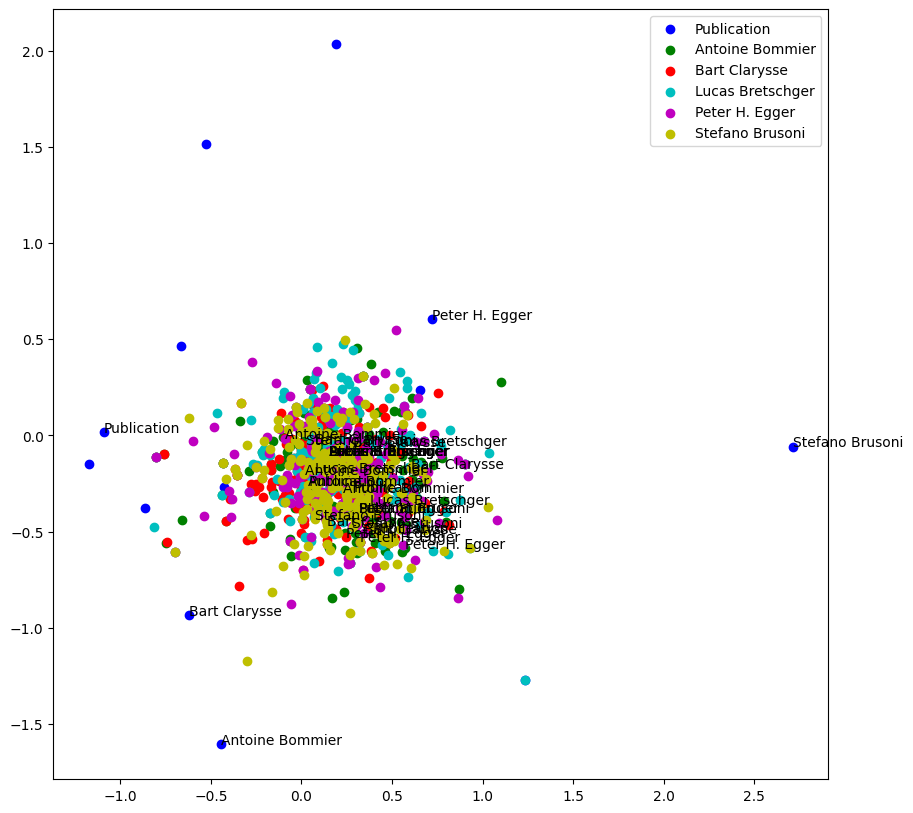

In [37]:
# Call the function
plot_sentence_embeddings(df, df_pub, model)

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def get_word_vector(word, model):
    try:
        return model[word]
    except KeyError:
        return np.zeros((model.vector_size,))

import matplotlib.patches as mpatches

def plot_sentence_embeddings(df_250, df_15, model):
    sentence_15 = df_15['keywords_extracted_updated_15_nongram'].values[0]
    sentences_250 = df_250['keywords_extracted_updated_250_nongram_authors'].values

    words_15 = sentence_15.split(' ')
    words_250 = [sentence.split(' ') for sentence in sentences_250]

    # get the word vectors
    vectors_15 = [get_word_vector(word, model) for word in words_15]
    vectors_250 = [[get_word_vector(word, model) for word in sentence] for sentence in words_250]

    # calculate the mean vector for each sentence
    mean_vector_15 = np.mean(vectors_15, axis=0)
    mean_vectors_250 = [np.mean(sentence, axis=0) for sentence in vectors_250]

    # Perform PCA
    pca = PCA(n_components=2)
    mean_vectors = np.vstack([mean_vector_15] + mean_vectors_250)
    mean_vectors_2d = pca.fit_transform(mean_vectors)

    # Plotting
    plt.figure(figsize=(10, 10)) # Increase the size of the plot
    ax = plt.gca()

    # Use different colors for different sentences
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Add labels for the points
    labels = ['Publication'] + list(df_250['author'])

    # Calculate distances and find the smallest
    distances = [np.linalg.norm(mean_vectors_2d[0] - mean_vectors_2d[i]) for i in range(1, len(mean_vectors_2d))]
    min_distance_index = np.argmin(distances) + 1  # add 1 because the Publication is at index 0

    for i, vector_2d in enumerate(mean_vectors_2d):
        x, y = vector_2d

        # change publication label to square
        if labels[i] == 'Publication':
            ax.scatter(x, y, color=colors[i % len(colors)], label=labels[i], marker='s') # Add label for each scatter plot
        else:
            ax.scatter(x, y, color=colors[i % len(colors)], label=labels[i]) # Add label for each scatter plot

        ax.annotate(labels[i], (x, y), xytext=(x+0.18, y),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=0.05, headwidth=5))  # Add an arrow between the label and the point

    # Add a legend to the plot
    plt.legend(loc='best')

    # remove the top and right lines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Add lines between points
    for i in range(1, len(mean_vectors_2d)):
        if i == min_distance_index:
            plt.plot([mean_vectors_2d[0, 0], mean_vectors_2d[i, 0]], [mean_vectors_2d[0, 1], mean_vectors_2d[i, 1]], 'r-', linewidth=2)
            ax.annotate('Top Ranked Author', (mean_vectors_2d[0, 0] + (mean_vectors_2d[i, 0] - mean_vectors_2d[0, 0])/2 - 0.27,
                                             mean_vectors_2d[0, 1] + (mean_vectors_2d[i, 1] - mean_vectors_2d[0, 1])/2), color='red', fontsize=12)
        else:
            plt.plot([mean_vectors_2d[0, 0], mean_vectors_2d[i, 0]], [mean_vectors_2d[0, 1], mean_vectors_2d[i, 1]], 'k--')

    plt.show()



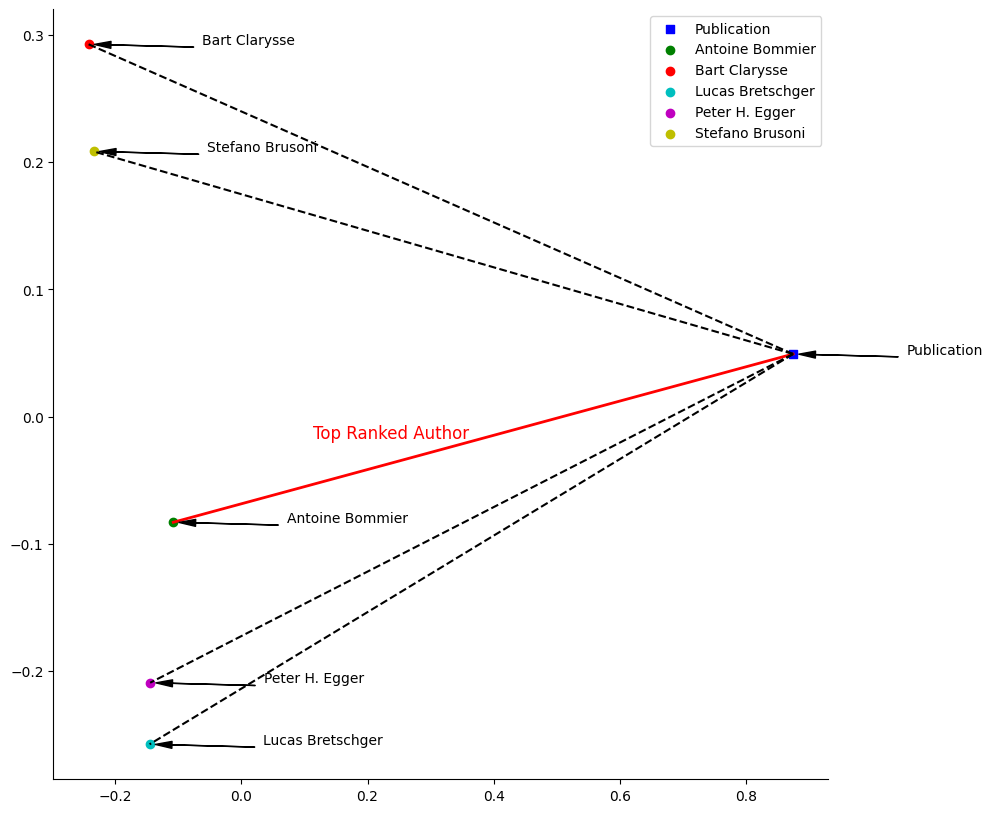

In [71]:
# Call the function
plot_sentence_embeddings(df, df_pub, model)

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the list of authors and their scores
author_scores = [item for sublist in df_updated['results'].dropna() for item in sublist]

# Separate the authors and scores into two lists
authors, scores = zip(*author_scores)

# Count the occurrences of each author
author_counts = Counter(authors)

# Prepare the data for the histogram
author_labels, author_values = zip(*author_counts.items())

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.barh(author_labels, author_values)
plt.xlabel('Count')
plt.ylabel('Author')
plt.title('Histogram of Top Authors')
plt.show()


In [ ]:
import seaborn as sns

# Create a DataFrame from the authors and scores
score_df = pd.DataFrame({'Author': authors, 'Score': scores})

# Plot the boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='Score', y='Author', data=score_df)
plt.title('Boxplot of Author Scores')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten the list of authors and their scores
author_scores = [item for sublist in df_updated['results'].dropna() for item in sublist]

# Separate the authors and scores into two lists
authors, scores = zip(*author_scores)

# Create a DataFrame from the authors and scores
score_df = pd.DataFrame({'Author': authors, 'Score': scores})

# Plot the scatter plot
plt.figure(figsize=(15, 10))
sns.stripplot(y='Author', x='Score', data=score_df, jitter=True)
plt.xlabel('Similarity Score')
plt.ylabel('Author')
plt.title('Scatter Plot of Author Similarity Scores')
plt.show()
